In [49]:
# loading necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os

In [50]:
# # reading data
df = pd.read_csv("masters/data.csv")
# df.head()
# df.shape

(100000, 6)

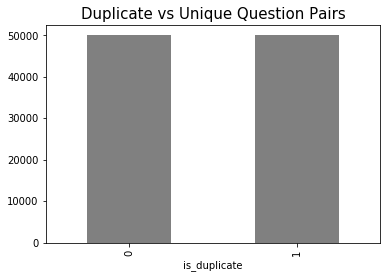

In [51]:
df = df.groupby('is_duplicate',as_index = False,group_keys=False).apply(lambda s: s.sample(50000,replace=True,random_state = 123))
df.shape
df.groupby("is_duplicate")['id'].count().plot.bar(color="grey").set_title('Duplicate vs Unique Question Pairs', fontsize=15)
df.head()
df.shape

In [52]:
# source: https://www.kaggle.com/currie32/the-importance-of-cleaning-text
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

def clean(text, stem_words=True):
    import re
    from string import punctuation

    # Clean the text
#     text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    # indian dollar
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
    
    # Optionally, remove stop words
#     if remove_stop_words:
#         text = text.split()
#         text = [w for w in text if not w in stop_words]
#         text = " ".join(text)
    
    # Optionally, shorten words to their stems
#     if lem_words:
#         text = text.split()
#         lem = WordNetLemmatizer()
#         lem_words = [lem.lemmatize(word) for word in text]
#         text = " ".join(lem_words)
    return text
    
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

In [54]:
# replacing NULL values with space
df = df.fillna('')
df[df.isnull().any(1)]

# checking missing values
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


### Word2Vec (WMD)

In [35]:
from gensim.models import KeyedVectors
from gensim import corpora, models, similarities
from gensim.models import Word2Vec

w2v_model = models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [55]:
from nltk.corpus import stopwords
from nltk import word_tokenize

# calculating Word Mover's Distance
def wmd(q1, q2):
#     splitting sentence on tokens
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
# filtering stop words
    stop_words = stopwords.words('english')
    q1 = [w2v_model for w2v_model in q1 if w2v_model not in stop_words]
    q2 = [w2v_model for w2v_model in q2 if w2v_model not in stop_words]
    
    return w2v_model.wmdistance(q1, q2)
#     applying wmd()
df['wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)  

In [56]:
# Normalizing word2vec vectors to calculate normalized wmd
w2v_model.init_sims(replace=True)  

In [57]:
# computing normalized WMD
df['norm_wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)

### Word2Vec (cosine)

In [58]:
# calculating cosine similarity based on word2vec
import numpy as np
from scipy import spatial 

global_index2word_set = set(w2v_model.wv.index2word)


def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
        if (n_words > 0):
            feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Calculate similarity:

def w2v_cosine (sentence1,sentence2,model, num_features, index2word_set):
    vec1 = avg_feature_vector(sentence1, model, num_features, index2word_set)
    vec2 = avg_feature_vector(sentence2, model, num_features, index2word_set)
    sim =  1 - spatial.distance.cosine(vec1, vec2)
    return sim

def w2v_manh (sentence1,sentence2,model, num_features, index2word_set):
    vec1 = avg_feature_vector(sentence1, model, num_features, index2word_set)
    vec2 = avg_feature_vector(sentence2, model, num_features, index2word_set)
    sim2 =  1 - spatial.distance.cityblock(vec1, vec2)
    return sim2

df['w2v_cosine'] = df.apply(lambda x: w2v_cosine(x['question1'], x['question2'], model=w2v_model, num_features=300,index2word_set = global_index2word_set), axis=1)

df['w2v_Manhattan'] = df.apply(lambda x: w2v_manh(x['question1'], x['question2'], model=w2v_model, num_features=300,index2word_set = global_index2word_set), axis=1)


/Users/Olga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [59]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,wmd,norm_wmd,w2v_cosine,w2v_Manhattan
395627,395648,494699,528639,does crow see from just one eye,how far can one see with the naked eye how is ...,0,0.656735,0.656735,0.007304,-1.356412
25052,25054,46729,46730,how do i unblock fortiguard application control,how can i unblock torrents,0,0.899362,0.899362,0.112670,-2.680161
44746,44749,80277,80278,how can i make money off bitcoin,can you make money with bitcoin,0,0.000000,0.000000,0.272492,0.382274
28221,28223,52353,52354,who is the head of immigration officer of mala...,how do avascular plants and vascular plants di...,0,1.360078,1.360078,0.011833,-1.791117
306360,306380,429895,429896,what is ionizing radiation,can you feel ionizing radiation,0,0.455592,0.455592,0.982493,-0.249461


In [60]:
df_sim = df.drop(['question1', 'question2', 'id', 'qid1', 'qid2'], axis=1)
df_sim.head()

,is_duplicate,wmd,norm_wmd,w2v_cosine,w2v_Manhattan
395627,0,0.656735,0.656735,0.007304,-1.356412
25052,0,0.899362,0.899362,0.112670,-2.680161
44746,0,0.000000,0.000000,0.272492,0.382274
28221,0,1.360078,1.360078,0.011833,-1.791117
306360,0,0.455592,0.455592,0.982493,-0.249461


In [61]:
from sklearn.model_selection import train_test_split
import scipy 
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

df_sim = df_sim.fillna(df_sim.median()).clip(-1e11,1e11)

X = df_sim.drop(['is_duplicate'],axis=1)
y = df_sim['is_duplicate']
X_train,X_test,y_train,y_test = train_test_split(X, y , test_size = 0.3, random_state = 123)


models = []

models.append(("LogisticRegression",LogisticRegression()))
models.append(("XGBoost", xgb.XGBClassifier()))
models.append(("RandomForest",RandomForestClassifier()))

results = []
names = []
for name,model in models:
    result = cross_val_score(model, X_train, y_train,  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())


LogisticRegression 0.5264714381739327
XGBoost 0.7254857323366751
RandomForest 0.7319713751974856


In [62]:
from sklearn.metrics import roc_auc_score

# build XGboost model
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
# making predictions
xgb_prediction = xgb_model.predict(X_test)

# performance assessment
print(classification_report(y_test, xgb_prediction))

print(roc_auc_score(y_test, xgb_prediction))

              precision    recall  f1-score   support

           0       0.77      0.65      0.70     15137
           1       0.69      0.80      0.74     14863

    accuracy                           0.72     30000
   macro avg       0.73      0.72      0.72     30000
weighted avg       0.73      0.72      0.72     30000

0.7249194378352388


In [63]:
from sklearn.metrics import roc_auc_score

# build rf model
rf_model = RandomForestClassifier(max_depth=50, n_estimators=80).fit(X_train, y_train) 
# making predictions
rf_prediction = rf_model.predict(X_test)

# performance assessment
print(classification_report(y_test, rf_prediction))

print(roc_auc_score(y_test, rf_prediction))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73     15137
           1       0.72      0.78      0.75     14863

    accuracy                           0.74     30000
   macro avg       0.74      0.74      0.74     30000
weighted avg       0.74      0.74      0.74     30000

0.7421700079505744


### SIF

In [64]:
import nltk
from sklearn.metrics.pairwise import cosine_similarity

STOP = set(nltk.corpus.stopwords.words("english"))


class Sentence:

    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'").replace("“", "").replace("”","")
        self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        self.tokens_without_stop = [t for t in self.tokens if t not in STOP]


import csv


def read_tsv(f):
    freq = {}
    with open(f) as tsv:
        tsv_reader = csv.reader(tsv, delimiter=' ')
        for row in tsv_reader:
            freq[row[0]] = int(row[1])
    return freq

from sklearn.decomposition import TruncatedSVD


def del_princ_comp(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=123)
    svd.fit(X)
    pc = svd.components_
    XX = X - X.dot(pc.transpose()) * pc
    return XX

faulty_shit = []

def sif(sentences1, sentences2, model, freqs={}, use_stoplist=False, a=0.001):
    total_freq = sum(freqs.values())
    embeddings = []
    for (sent1, sent2) in zip(sentences1, sentences2):
        tokens1 = sent1.tokensk_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens

        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]

        weights1 = [a / (a + freqs.get(token, 0) / total_freq) for token in tokens1]
        weights2 = [a / (a + freqs.get(token, 0) / total_freq) for token in tokens2]

        embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
        embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)

        embeddings.append(embedding1)
        embeddings.append(embedding2)

    embeddings = del_princ_comp(np.array(embeddings))
    sims = [cosine_similarity(embeddings[idx * 2].reshape(1, -1),
                              embeddings[idx * 2 + 1].reshape(1, -1))[0][0]
            for idx in range(int(len(embeddings) / 2))]
 
    return sims




frenquencies = read_tsv("/Users/Olga/PycharmProjects/data/frequencies.txt")
sentences1 = [Sentence(s) for s in df['question1']]
sentences2 = [Sentence(s) for s in df['question2']]
sims = sif(sentences1, sentences2, model=w2v_model, freqs=frenquencies, use_stoplist=False, a=0.001)
df['SIF'] = np.array(sims)


In [65]:
df.isnull().sum()

id               0
qid1             0
qid2             0
question1        0
question2        0
is_duplicate     0
wmd              0
norm_wmd         0
w2v_cosine       0
w2v_Manhattan    0
SIF              0
dtype: int64

In [66]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,wmd,norm_wmd,w2v_cosine,w2v_Manhattan,SIF
395627,395648,494699,528639,does crow see from just one eye,how far can one see with the naked eye how is ...,0,0.656735,0.656735,0.007304,-1.356412,0.400244
25052,25054,46729,46730,how do i unblock fortiguard application control,how can i unblock torrents,0,0.899362,0.899362,0.112670,-2.680161,0.622001
44746,44749,80277,80278,how can i make money off bitcoin,can you make money with bitcoin,0,0.000000,0.000000,0.272492,0.382274,0.594603
28221,28223,52353,52354,who is the head of immigration officer of mala...,how do avascular plants and vascular plants di...,0,1.360078,1.360078,0.011833,-1.791117,-0.040175
306360,306380,429895,429896,what is ionizing radiation,can you feel ionizing radiation,0,0.455592,0.455592,0.982493,-0.249461,0.713251


In [67]:
df_sim = df.drop(['question1', 'question2', 'id', 'qid1', 'qid2'], axis=1)
df_sim.head()

,is_duplicate,wmd,norm_wmd,w2v_cosine,w2v_Manhattan,SIF
395627,0,0.656735,0.656735,0.007304,-1.356412,0.400244
25052,0,0.899362,0.899362,0.112670,-2.680161,0.622001
44746,0,0.000000,0.000000,0.272492,0.382274,0.594603
28221,0,1.360078,1.360078,0.011833,-1.791117,-0.040175
306360,0,0.455592,0.455592,0.982493,-0.249461,0.713251


In [68]:
df_sim.shape

(100000, 6)

In [69]:
from sklearn.model_selection import train_test_split
import scipy 
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

df_sim = df_sim.fillna(df_sim.median()).clip(-1e11,1e11)

X = df_sim.drop(['is_duplicate'],axis=1)
y = df_sim['is_duplicate']
X_train,X_test,y_train,y_test = train_test_split(X, y , test_size = 0.3, random_state = 123)


models = []

models.append(("LogisticRegression",LogisticRegression()))
models.append(("XGBoost", xgb.XGBClassifier()))
models.append(("RandomForest",RandomForestClassifier()))

results = []
names = []
for name,model in models:
    result = cross_val_score(model, X_train, y_train,  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

LogisticRegression 0.5276285816437841
XGBoost 0.7281286064191445
RandomForest 0.7436285400998877


In [70]:
from sklearn.metrics import roc_auc_score

# build XGboost model
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
# making predictions
xgb_prediction = xgb_model.predict(X_test)

# performance assessment
print(classification_report(y_test, xgb_prediction))

print(roc_auc_score(y_test, xgb_prediction))

              precision    recall  f1-score   support

           0       0.78      0.66      0.71     15137
           1       0.70      0.81      0.75     14863

    accuracy                           0.73     30000
   macro avg       0.74      0.74      0.73     30000
weighted avg       0.74      0.73      0.73     30000

0.7350394620251678


In [71]:
from sklearn.metrics import roc_auc_score

# build rf model
rf_model = RandomForestClassifier(max_depth=50, n_estimators=80).fit(X_train, y_train) 
# making predictions
rf_prediction = rf_model.predict(X_test)

# performance assessment
print(classification_report(y_test, rf_prediction))

print(roc_auc_score(y_test, rf_prediction))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74     15137
           1       0.73      0.81      0.77     14863

    accuracy                           0.75     30000
   macro avg       0.76      0.75      0.75     30000
weighted avg       0.76      0.75      0.75     30000

0.7544940315487917


### Basic + Fuzzy + Similarity 

In [111]:
#  data set with similarity measures
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,wmd,norm_wmd,w2v_cosine,w2v_Manhattan,SIF
395627,395648,494699,528639,does crow see from just one eye,how far can one see with the naked eye how is ...,0,0.656735,0.656735,0.007304,-1.356412,0.400244
25052,25054,46729,46730,how do i unblock fortiguard application control,how can i unblock torrents,0,0.899362,0.899362,0.112670,-2.680161,0.622001
44746,44749,80277,80278,how can i make money off bitcoin,can you make money with bitcoin,0,0.000000,0.000000,0.272492,0.382274,0.594603
28221,28223,52353,52354,who is the head of immigration officer of mala...,how do avascular plants and vascular plants di...,0,1.360078,1.360078,0.011833,-1.791117,-0.040175
306360,306380,429895,429896,what is ionizing radiation,can you feel ionizing radiation,0,0.455592,0.455592,0.982493,-0.249461,0.713251


In [112]:
df_cl = df.drop(['question1', 'question2', 'qid1', 'qid2'], axis=1)
df_cl.head()

,id,is_duplicate,wmd,norm_wmd,w2v_cosine,w2v_Manhattan,SIF
395627,395648,0,0.656735,0.656735,0.007304,-1.356412,0.400244
25052,25054,0,0.899362,0.899362,0.112670,-2.680161,0.622001
44746,44749,0,0.000000,0.000000,0.272492,0.382274,0.594603
28221,28223,0,1.360078,1.360078,0.011833,-1.791117,-0.040175
306360,306380,0,0.455592,0.455592,0.982493,-0.249461,0.713251


In [113]:
df2 = pd.read_csv("masters/df_basic.csv")

In [114]:
# data set with basic and fuzzy features
df2.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,num_words_q1,num_words_q2,len_q1,...,ct_min,ct_max,token_len_abs,token_len_avg,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,395627,395648,494699,528639,does crow see from just one eye,how far can one see with the naked eye how is ...,0,8,14,32,...,0.428571,0.230769,6.0,10.0,40,56,100,52,52,43
1,25052,25054,46729,46730,how do i unblock fortiguard application control,how can i unblock torrents,0,8,6,48,...,0.600000,0.428571,2.0,6.0,56,67,100,58,67,49
2,44746,44749,80277,80278,how can i make money off bitcoin,can you make money with bitcoin,0,8,7,33,...,0.666667,0.571429,1.0,6.5,77,82,100,77,86,76
3,28221,28223,52353,52354,who is the head of immigration officer of mala...,how do avascular plants and vascular plants di...,0,10,9,51,...,0.000000,0.000000,1.0,8.5,37,37,37,32,36,32
4,306360,306380,429895,429896,what is ionizing radiation,can you feel ionizing radiation,0,5,6,27,...,0.500000,0.400000,1.0,4.5,75,78,100,79,82,67


In [115]:
df2_cl = df2.drop(['question1', 'question2', 'qid1', 'qid2', 'Unnamed: 0','is_duplicate'], axis=1)
df2_cl.head()

,id,num_words_q1,num_words_q2,len_q1,len_q2,word_share,cw_min,cw_max,cs_min,cs_max,ct_min,ct_max,token_len_abs,token_len_avg,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,395648,8,14,32,62,0.190476,0.75,0.500000,0.000000,0.000000,0.428571,0.230769,6.0,10.0,40,56,100,52,52,43
1,25054,8,6,48,27,0.285714,0.50,0.250000,0.666667,0.666667,0.600000,0.428571,2.0,6.0,56,67,100,58,67,49
2,44749,8,7,33,32,0.333333,1.00,1.000000,0.333333,0.250000,0.666667,0.571429,1.0,6.5,77,82,100,77,86,76
3,28223,10,9,51,51,0.058824,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,8.5,37,37,37,32,36,32
4,306380,5,6,27,32,0.272727,1.00,0.666667,0.000000,0.000000,0.500000,0.400000,1.0,4.5,75,78,100,79,82,67


In [116]:
#  merging two data sets to get total set of features
df_total = pd.merge(df_cl,df2_cl, on = 'id')

In [117]:
df_total.head()

,id,is_duplicate,wmd,norm_wmd,w2v_cosine,w2v_Manhattan,SIF,num_words_q1,num_words_q2,len_q1,...,ct_min,ct_max,token_len_abs,token_len_avg,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,395648,0,0.656735,0.656735,0.007304,-1.356412,0.400244,8,14,32,...,0.428571,0.230769,6.0,10.0,40,56,100,52,52,43
1,25054,0,0.899362,0.899362,0.112670,-2.680161,0.622001,8,6,48,...,0.600000,0.428571,2.0,6.0,56,67,100,58,67,49
2,44749,0,0.000000,0.000000,0.272492,0.382274,0.594603,8,7,33,...,0.666667,0.571429,1.0,6.5,77,82,100,77,86,76
3,44749,0,0.000000,0.000000,0.272492,0.382274,0.594603,8,7,33,...,0.666667,0.571429,1.0,6.5,77,82,100,77,86,76
4,44749,0,0.000000,0.000000,0.272492,0.382274,0.594603,8,7,33,...,0.666667,0.571429,1.0,6.5,77,82,100,77,86,76


In [118]:
df_total.shape

(126556, 26)

In [119]:
df_total = df_total.drop_duplicates()

In [120]:
df_total.shape

(87862, 26)

In [121]:
df_total.head()
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87862 entries, 0 to 126555
Data columns (total 26 columns):
id                               87862 non-null int64
is_duplicate                     87862 non-null int64
wmd                              87862 non-null float64
norm_wmd                         87862 non-null float64
w2v_cosine                       87862 non-null float64
w2v_Manhattan                    87862 non-null float64
SIF                              87862 non-null float64
num_words_q1                     87862 non-null int64
num_words_q2                     87862 non-null int64
len_q1                           87862 non-null int64
len_q2                           87862 non-null int64
word_share                       87862 non-null float64
cw_min                           87862 non-null float64
cw_max                           87862 non-null float64
cs_min                           87862 non-null float64
cs_max                           87862 non-null float64
ct_min

In [126]:
from sklearn.model_selection import train_test_split
import scipy 
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

df_total = df_total.fillna(df_sim.median()).clip(-1e11,1e11)

X = df_total.drop(['is_duplicate'],axis=1)
y = df_total['is_duplicate']
X_train,X_test,y_train,y_test = train_test_split(X, y , test_size = 0.3, random_state = 123)


models = []

models.append(("LogisticRegression",LogisticRegression()))
models.append(("XGBoost", xgb.XGBClassifier()))
models.append(("RandomForest",RandomForestClassifier()))

results = []
names = []
for name,model in models:
    result = cross_val_score(model, X_train, y_train,  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

LogisticRegression 0.5156496431068404
XGBoost 0.7579630261938441
RandomForest 0.7605970440466319


In [127]:
from sklearn.metrics import roc_auc_score

# build XGboost model
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
# making predictions
xgb_prediction = xgb_model.predict(X_test)

# performance assessment
print(classification_report(y_test, xgb_prediction))

print(roc_auc_score(y_test, xgb_prediction))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75     13771
           1       0.71      0.83      0.77     12588

    accuracy                           0.76     26359
   macro avg       0.77      0.76      0.76     26359
weighted avg       0.77      0.76      0.76     26359

0.7626483112010319


In [128]:
from sklearn.metrics import roc_auc_score

# build rf model
rf_model = RandomForestClassifier(max_depth=50, n_estimators=80).fit(X_train, y_train) 
# making predictions
rf_prediction = rf_model.predict(X_test)

# performance assessment
print(classification_report(y_test, rf_prediction))

print(roc_auc_score(y_test, rf_prediction))

              precision    recall  f1-score   support

           0       0.82      0.70      0.75     13771
           1       0.71      0.83      0.77     12588

    accuracy                           0.76     26359
   macro avg       0.77      0.76      0.76     26359
weighted avg       0.77      0.76      0.76     26359

0.7634663385062169
